# Notebook For Figure 1 Method Paper

### Imports  
All functions are in behavior_analysis_functions.py

In [68]:
import os
import glob
from processing_TowerCoordinates import *
from processing_session_trajectory import *
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib.path as mpath
import matplotlib.cm as cm
import matplotlib.patches as patches
from matplotlib.gridspec import GridSpec
from matplotlib.colors import Normalize
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np
import pickle
import scipy.ndimage as ndimage
from scipy.stats import wilcoxon
from processing_TowerCoordinates import *
from datetime import date
from scipy.ndimage import gaussian_filter as smooth
import matplotlib.colors as mcolors

import warnings 
from matplotlib.colors import LinearSegmentedColormap


plt.style.use('paper.mplstyle')

#from PlottingFunctions import *




In [ ]:
# TODO
# Mieux positionner les légendes
# Mieux positionner les noms des panels
# Aligner les panels C, D et E pour que ce soit clair qu'ils correspondent aux mêmes sessions (verticalement)
# La E je ne mettrais pas la même échelle en y
# Et C D et E title for X axis
# étendre E3 bad turns jusqu'à 600

# Getting mice data
Define the folder where your MOUXXX folder are, generate a list of MOUXXX folders and for each mice a list of sessions

In [69]:
# Finding and importing data

# indicate where the data are
# path_to_data_folder is the path of the folder where you store your different mice.

# Windows:
# path_to_data_folder='C:'+os.sep+'Users'+os.sep+'MORVAN'+os.sep+'Documents'+os.sep+'patchouris'+os.sep+'Sample_Data'+os.sep
# Linux:
# path_to_data_folder '/home/david/Documents/Code/ForagingProject/Patchouris/patchouris/Sample_Data/'
# MacOs
#path_to_data_folder = '/Users/davidrobbe/Documents/Science/Data/ForagingMice/'


#path_to_data_folder='/home/david/Documents/David/Data/'
#path_to_data_folder='/LocalData/ForagingMice/JAK2Data'
#path_to_data_folder='/LocalData/ForagingMice/MaudData'
path_to_data_folder='/LocalData/ForagingMice/4TowerTaskMethodPaper/KenzaData'
#path_to_data_folder = '/Users/davidrobbe/Documents/Science/Data/ForagingMice/KenzaData'


pattern_of_MOU_Folders = os.path.join(path_to_data_folder, "MOU*")

# List all mice in the data folder (If you want to process all the mice in your data folder),
mice_list = [os.path.basename(path) for path in glob.glob(pattern_of_MOU_Folders)]
mice_list=sorted(mice_list)

# Print the number of mice, the list of mice, and add an empty line
print(f'Found {len(mice_list)} {"mice" if len(mice_list) > 1 else "mouse"} in the data folder: {", ".join(mice_list)}\n')


#If you want to process a subset of mice uncomment the line below and comment the 2 lines above

#mice_list: list[str] = ["MOU2334"]  # For processing  a single mice. Equivalent to mice_list = ["MOU2334"] but more correct as it forces to create a list of string
#mice_list=['MOU2329', 'MOU2330', 'MOU2331', 'MOU2332', 'MOU2333', 'MOU2334']
#print(f'Found {len(mice_list)} {"mice" if len(mice_list) > 1 else "mouse"} in the data folder:')

session_list = {}
for mouse in mice_list:
    mouse_folder = os.path.join(path_to_data_folder,mouse)
    session_list[mouse] = sorted([name for name in os.listdir(mouse_folder)
                           if os.path.isdir(os.path.join(mouse_folder, name))
                           and name.startswith('MOU')])
    nb_sessions = len(session_list[mouse])
    print(f'Hello, I\'m {mouse}! I have foraged for {nb_sessions} sessions:')
    print(session_list[mouse], '\n')


Found 36 mice in the data folder: MOUKA266, MOUKA267, MOUKA268, MOUKA269, MOUKA270, MOUKA271, MOUKA274, MOUKA275, MOUKA276, MOUKA277, MOUKA278, MOUKA279, MOUKA286, MOUKA287, MOUKA288, MOUKA289, MOUKA290, MOUKA291, MOUKA296, MOUKA297, MOUKA298, MOUKA299, MOUKA300, MOUKA301, MOUKA302, MOUKA303, MOUKA304, MOUKA305, MOUKA306, MOUKA307, MOUKA308, MOUKA309, MOUKA310, MOUKA311, MOUKA312, MOUKA313

Hello, I'm MOUKA266! I have foraged for 17 sessions:
['MOUKA266_20230531-1433', 'MOUKA266_20230601-0925', 'MOUKA266_20230601-1507', 'MOUKA266_20230602-0857', 'MOUKA266_20230602-1450', 'MOUKA266_20230605-0924', 'MOUKA266_20230605-1606', 'MOUKA266_20230606-1052', 'MOUKA266_20230606-1626', 'MOUKA266_20230607-0929', 'MOUKA266_20230607-1439', 'MOUKA266_20230608-0949', 'MOUKA266_20230608-1538', 'MOUKA266_20230609-1034', 'MOUKA266_20230609-1604', 'MOUKA266_20230612-0941', 'MOUKA266_20230612-1505'] 

Hello, I'm MOUKA267! I have foraged for 18 sessions:
['MOUKA267_20230531-1519', 'MOUKA267_20230601-0939', 'M

# Definition of functions

In [70]:
def cm2inch(value):
    return value/2.54

In [71]:
def compute_average_direction(points):
    diffs = np.diff(points, axis=0)
    avg_diff = np.mean(diffs, axis=0)
    angle = np.arctan2(avg_diff[1], avg_diff[0])
    return avg_diff, angle

In [72]:
def detect_run_epochs(speeds, time_video_frames):
    """
    
    Identifies continuous epochs during which the mouse is moving above a certain speed (cut_off_speed).
    A minimal duration of low speed is necessary to be considered as the end of a run.
    Similarly, a minimal duration of high speed is necessary to be considered as a run.
    """
    
    #for this we need some parameters to cut the trajectory into run based on speed, duration of runs and pauses
    pause_min_duration = 0.1 #if a stop is shorter than this, merges the two epochs bordering it
    run_min_duration = 0.3 #minimal duration of an epoch to be considerd
    cut_off_speed = 7 # this value is the speed in cm/s. It is used to detect when the animals stop running. 
    
    
    
    run_epochs = []
    is_in_epoch = False  # Flag to track if we are currently in a running epoch
    epoch_start_index = 0

    if len(speeds) != len(time_video_frames):
        raise ValueError("speeds and time_video_frames have different lengths")

    for i in range(len(speeds)):
        if speeds[i] >= cut_off_speed:  # Speed above cut-off value
            if not is_in_epoch: # if the previous trajectory speed was not part of running epoch then this will be a start of a new epoch
                epoch_start_index = i  # Mark the beginning of a new epoch
                is_in_epoch = True
        else: # the speed of the current data point is below the treshold
            if is_in_epoch: # if we were in a run epoch just before (1st point below the treshold)
                # Check first if the pause between this epoch's starting point (time_video_frames[epoch_start_index]) and  
                # the previous epoch' last point time_video_frames[run_epochs[-1][1]] is shorter than the minimal time for a pause
                # then the previous epoch  should be extended to the previous data point.  
                if run_epochs and (time_video_frames[epoch_start_index] - time_video_frames[run_epochs[-1][1]] < pause_min_duration):
                    run_epochs[-1][1] = i - 1  # Extend the previous epoch
                else: # the pause has been long enough then we terminate the run epoch  other previous 
                    run_epochs.append([epoch_start_index, i - 1])  # Add new epoch
                is_in_epoch = False

    # Final check for any epoch still in progress
    if is_in_epoch:
        if run_epochs and (time_video_frames[epoch_start_index] - time_video_frames[run_epochs[-1][1]] < pause_min_duration):
            run_epochs[-1][1] = len(speeds) - 1
        elif (time_video_frames[-1] - time_video_frames[epoch_start_index]) >= run_min_duration:
            run_epochs.append([epoch_start_index, len(speeds) - 1])

    # Remove epochs that are too short
    run_epochs = [epoch for epoch in run_epochs if (time_video_frames[epoch[1]] - time_video_frames[epoch[0]]) >= run_min_duration]
    
    # Adjust the start and end of each epoch based on acceleration. The idea is that with the threshold method we miss the beginning and enf of the run
    # for the starting point. We are going back and find the point at wich the animal acceleration is less than 40% 
    # than the acceleration at the moment at which he passed the treshold. 
    clean_run_epochs = [None] * len(run_epochs)
    for index,epoch in enumerate(run_epochs):
        clean_run_epochs[index] = epoch.copy()
        epoch_start, epoch_end = epoch[0], epoch[1]
        # Adjust the start of the epoch
        current_point = epoch_start
        acceleration_at_crossing=(speeds[current_point + 1] - speeds[current_point]) / (time_video_frames[current_point + 1] - time_video_frames[current_point])
        while current_point > 0:
            previous_acceleration = (speeds[current_point] - speeds[current_point - 1]) / (time_video_frames[current_point] - time_video_frames[current_point - 1])
            if previous_acceleration <= (0.1 * acceleration_at_crossing) or previous_acceleration <= 0:
                break
            current_point -= 1
            #print(f'it went backward on epoch {index}')
        clean_run_epochs[index][0] = current_point

    #Adjust the end of the epoch
    #We are going forward after the speed crossed downward the speed threshold and find the point at wich the animal acceleration is less than 40% 
    #than the acceleration at the moment at which it passed the treshold. 
        current_point = epoch_end
        acceleration_at_crossing=(speeds[current_point - 1] - speeds[current_point]) / (time_video_frames[current_point] - time_video_frames[current_point-1])
        while current_point < len(speeds) - 1:
            next_acceleration = (speeds[current_point] - speeds[current_point + 1]) / (time_video_frames[current_point+1] - time_video_frames[current_point])
            if next_acceleration <= (0.1 * acceleration_at_crossing) or next_acceleration <= 0:
                break
            current_point += 1
            #print(f'it went forward on epoch {index}')
        clean_run_epochs[index][1] = current_point

    
   
    return run_epochs, clean_run_epochs

In [73]:
def find_run_type(run_epoch, folder_path_mouse_to_process, session_to_process):

    # Define the pickle file path
    output_pickle_filename = f"{session_to_process}_basic_processing_output.pickle"
    output_pickle_filepath = os.path.join(folder_path_mouse_to_process, session_to_process, output_pickle_filename)
    
    # Load the pickle file
    with open(output_pickle_filepath, 'rb') as file:
        session_data = pickle.load(file)

    
    run_around_tower_ids = np.array([item[0] for item in session_data['all_epochs']['run_around_tower']])
    run_between_towers_ids = np.array([item[0] for item in session_data['all_epochs']['run_between_towers']])
    exploratory_run_ids = np.array([item[0] for item in session_data['all_epochs']['exploratory_run']])
    run_toward_tower_ids = np.array([item[0] for item in session_data['all_epochs']['run_toward_tower']])
    #print(immobility_ids)
    immobility_ids = np.array([[item[0],item[1]] for item in session_data['all_epochs']['immobility']])
    
    # condition_1 = np.logical_and(run_around_tower_ids[0][:]<=run_epoch[0],run_around_tower_ids[1][:]>run_epoch[1])
    # condition_2 = np.logical_and(run_between_towers_ids[0][:]<=run_epoch[0],run_between_towers_ids[1][:]>run_epoch[1])
    # condition_3 = np.logical_and(run_toward_tower_ids[0][:]<=run_epoch[0],run_toward_tower_ids[1][:]>run_epoch[1])
    # condition_4 = np.logical_and(exploratory_run_ids[0][:]<=run_epoch[0],exploratory_run_ids[1][:]>run_epoch[1])
    # condition_5 = np.logical_and(immobility_ids[0][:]<=run_epoch[0],immobility_ids[1][:]>run_epoch[1])
    
    condition_1 = run_epoch in run_around_tower_ids
    condition_2 = run_epoch in run_between_towers_ids
    condition_3 = run_epoch in run_toward_tower_ids
    condition_4 = run_epoch in exploratory_run_ids
    condition_5 = run_epoch in immobility_ids
    

    if np.any(condition_1):
    
        epoch_type = "run_around_tower"
        
    elif np.any(condition_2):
    
        epoch_type = "run_between_towers"

    elif np.any(condition_3):
    
        epoch_type = "run_toward_tower"    

    elif np.any(condition_4):
    
        epoch_type = "exploratory_run"

    elif np.any(condition_5):
    
        epoch_type = "immobility"    

    else:
        
        print("WARNING: unclassified epoch")
        epoch_type = "unclassified"

    #print(f"Epoch type found for epoch: {run_epoch}")


    return epoch_type


def plot_selected_run_epochs(traject_time, smoothed_positions_cm, run_epochs, turns_df, first_epoch_to_plot, last_epoch_to_plot, all_trapezes_coordinates_cm, ax, points_for_direction=4):
    
    run_types = ["run_around_tower", "run_between_towers", "run_toward_tower", "exploratory_run","immobility","unclassified"]
    #cmap = plt.get_cmap('viridis')
    #colors = cmap(np.linspace(0.2, 1, len(run_types))) 
    colors = ["blue","green", "orange", "red", "yellow", "black"]

    
    trapeze_switch_times=[]
    #ax.figure(figsize=(10, 8))
    all_start_end_indexes=[]

    for idx in range(first_epoch_to_plot, last_epoch_to_plot):
        
        run_epoch = run_epochs[idx]
        start_index, end_index = run_epoch[0], run_epoch[1]
        #print(start_index,end_index)
        all_start_end_indexes.extend([start_index,end_index])
        #print(all_start_end_indexes)

        # Check if the indexes are within the bounds of traj_df
        if start_index < 0 or end_index >= len(traject_time):
            print(f"Indexes out of bounds for run_epoch: {run_epoch}")
            continue

        # Extract the run_epoch segment        
        run_epoch = [smoothed_positions_cm[0][start_index: end_index+1],smoothed_positions_cm[1][start_index: end_index+1]]
        times_run_epoch=traject_time[start_index: end_index+1]
        
        # Plot the raw trajectory of this epoch 
        #ax.plot(run_epoch[0], run_epoch[1], linestyle='--', color='c')
        # Plot the smooth trajectory of this epoch 

        epoch_type = find_run_type(run_epoch, folder_path_mouse_to_process, session_to_process)

        color = colors[run_types.index(epoch_type)]
        
        ax.plot(smoothed_positions_cm[0][start_index: end_index+1],smoothed_positions_cm[1][start_index: end_index+1], color=color, linestyle='-', color='black')


        # Mark the beginning of the trajectory
        ax.plot(run_epoch[0][0], run_epoch[1][0], 
                 marker='o', color='black', markersize=2, 
                 label='Start' if idx == first_epoch_to_plot else "")

        # Draw an arrow at the end of the trajectory
        if idx+1 == last_epoch_to_plot:
            
            dx = smoothed_positions_cm[0][end_index+1] - smoothed_positions_cm[0][end_index+1-points_for_direction]
            dy = smoothed_positions_cm[1][end_index+1] - smoothed_positions_cm[1][end_index+1-points_for_direction]
            norm_speed = np.hypot(dx, dy)
            if norm_speed != 0:
                dx /= norm_speed
                dy /= norm_speed
            ax.arrow(smoothed_positions_cm[0][end_index+1], smoothed_positions_cm[1][end_index+1], dx, dy,
                                    head_width=2, head_length=2, fc='red', ec='red', zorder=100)        

        """ax.arrow(
            run_epoch[0][-2], run_epoch[1][-2], 
            avg_diff[0], avg_diff[1],
            shape='full', lw=0, length_includes_head=True, head_width=2, color='r',
            label='End' if idx == first_epoch_to_plot else "", zorder=5
        )"""

        # Annotate the number of the quarter turn next to its starting point
        # ax.text(run_epoch[0][0], run_epoch[1][0], f'{idx + 1}', fontsize=8, color='black', ha='right')

        # Find turn in the turns_df data frame within this quarter turn based on time
        turns_in_QT = turns_df[(turns_df['time'] >= times_run_epoch[0]) & (turns_df['time'] <= times_run_epoch[-1])]
        #print(turns_in_QT)
        trapeze_switch_times.extend(turns_in_QT['time'].values)
        # Plot the switch of trapez as a cross marker on the trajectory
        #ax.scatter(turns_in_QT['xposition']*conversion_factor, (video_resolution[1]-turns_in_QT['yposition'])*conversion_factor, marker='x', color='m', label='Turn Positions')

        # Add labels to turns indicating arrivalTrapeze, departureTrapeze, and currentPatchTower
        # for _, turn in turns_in_QT.iterrows():
        #     ax.text(turn['xposition']*conversion_factor, (video_resolution[1]-turn['yposition'])*conversion_factor, f"{turn['currentPatch']}\n{turn['previousTrapeze']}\n{turn['currentTrapeze']}",
        #              fontsize=8, color='black', ha='center', va='bottom')

       # Generate a color map using matplotlib's tab10 colormap (which has 10 distinct colors) to plot the trapezes
    colors = list(mcolors.TABLEAU_COLORS.values())  # Using Tableau colors for distinct colors
    
    # Plot each square and trapeze with the same color for each tower
    # for i, (tower, trapezes) in enumerate(all_trapezes_coordinates_cm.items()):
    #     tower_color = colors[i % len(colors)]  # Cycle through the colors if there are more than 10 towers
    #     for trapeze, coordinates in trapezes.items():
    #         # Make a copy of the coordinates and close the polygon by appending the first vertex
    #         coordinates_copy = coordinates + [coordinates[0]]
    #         # Extract x and y coordinates for plotting
    #         x_coords, y_coords = zip(*coordinates_copy)
    #         ax.plot(x_coords, y_coords, label=f'{tower}_{trapeze}', color=tower_color,linestyle='--')

    # Plot the trapezes with varying border and fill colors
    
    #border_colors = ['black'] * 4
    fill_colors = ['lightblue'] * 4
    
    for i, (tower, trapezes) in enumerate(all_trapezes_coordinates_cm.items()):
        for j, (trapeze, coordinates) in enumerate(trapezes.items()):
            # Close the polygon by appending the first vertex
            coordinates_copy = coordinates + [coordinates[0]]
            x_coords, y_coords = zip(*coordinates_copy)
            
            # Fill the trapezes if requested
            ax.fill(x_coords, y_coords, color=fill_colors[j % len(fill_colors)], alpha=0.5)
            
            # Plot trapeze borders if requested
            #ax.plot(x_coords, y_coords, color=border_colors[j % len(border_colors)], linestyle='--')

    # Set plot limits and labels
  
    for spine in ax.spines.values():
        spine.set_visible(False)

    ax.set_xticks([])
    ax.set_yticks([])

    #ax.set_title(f'Selected Quarter Turns: QT {first_epoch_to_plot + 1} to QT {last_epoch_to_plot}')
    #plt.legend()
    #plt.gca().invert_yaxis()  # Invert the y-axis
    
    return all_start_end_indexes[0], all_start_end_indexes[-1],trapeze_switch_times

In [94]:
def plot_selected_run_epochs(folder_path_mouse_to_process, session_to_process, first_epoch_to_plot, last_epoch_to_plot, all_trapezes_coordinates_cm, ax, points_for_direction=4, show_legend=True):
    
    output_pickle_filename = f"{session_to_process}_basic_processing_output.pickle"        
    output_pickle_filepath = os.path.join(folder_path_mouse_to_process, session_to_process, output_pickle_filename)

    with open(output_pickle_filepath, 'rb') as file:
        session_data = pickle.load(file)

    traj_df, turns_df, param_df=load_data(folder_path_mouse_to_process,session_to_process)

    traject_time = session_data['timeofframes']

    """if time_start is None:
        time_start = traject_time[0]
    if time_end is None:
        time_end = traject_time[-1]
    """
    speeds = session_data['speeds']

    smoothed_positions = session_data['positions']
    smoothed_Xpositions = smoothed_positions[0]
    smoothed_Ypositions = smoothed_positions[1]

    run_epochs, clean_run_epochs = detect_run_epochs(speeds,traject_time)

    run_types = ["run_around_tower", "run_between_towers", "run_toward_tower", "exploratory_run","immobility","unclassified"]
    type_names = ["Run around tower", "Run between towers", "Run toward tower", "Exploratory run","Immobility","Unclassified"]

    #cmap = plt.get_cmap('viridis')
    #colors = cmap(np.linspace(0.2, 1, len(run_types))) 
    colors = ["mediumslateblue", "green", "orange", "red", "yellow", "black"]
    
    trapeze_switch_times=[]
    #ax.figure(figsize=(10, 8))
    all_start_end_indexes=[]

    labels_displayed = set()

    for idx in range(first_epoch_to_plot, last_epoch_to_plot):
        
        run_epoch = clean_run_epochs[idx]
        start_index, end_index = run_epoch[0], run_epoch[1]
        #print(start_index,end_index)
        all_start_end_indexes.extend([start_index,end_index])
        #print(all_start_end_indexes)

        # Check if the indexes are within the bounds of traj_df
        if start_index < 0 or end_index >= len(traject_time):
            print(f"Indexes out of bounds for run_epoch: {run_epoch}")
            continue

        # Extract the run_epoch segment        
        run_epoch = [smoothed_Xpositions[start_index: end_index+1],smoothed_Ypositions[start_index: end_index+1]]
        times_run_epoch=traject_time[start_index: end_index+1]
        
        # Plot the raw trajectory of this epoch 
        #ax.plot(run_epoch[0], run_epoch[1], linestyle='--', color='c')
        # Plot the smooth trajectory of this epoch 

        epoch_type = find_run_type([start_index,end_index], folder_path_mouse_to_process, session_to_process)

        color = colors[run_types.index(epoch_type)]
        
        if not(color in labels_displayed):

                line_label = type_names[run_types.index(epoch_type)]
                labels_displayed.add(color)

        else:

            line_label = ''

        ax.plot(smoothed_Xpositions[start_index: end_index+1],smoothed_Ypositions[start_index: end_index+1], color=color, linestyle='-', label=line_label)


        # Mark the beginning of the trajectory
        ax.plot(run_epoch[0][0], run_epoch[1][0], 
                 marker='o', color='black', markersize=2)

        # Draw an arrow at the end of the trajectory
        if idx+1 == last_epoch_to_plot:
            
            dx = smoothed_Xpositions[end_index+1] - smoothed_Xpositions[end_index+1-points_for_direction]
            dy = smoothed_Ypositions[end_index+1] - smoothed_Ypositions[end_index+1-points_for_direction]
            norm_speed = np.hypot(dx, dy)
            if norm_speed != 0:
                dx /= norm_speed
                dy /= norm_speed
            ax.arrow(smoothed_Xpositions[end_index+1], smoothed_Ypositions[end_index+1], dx, dy,
                                    head_width=2, head_length=2, fc='red', ec='red', zorder=100)        

        """ax.arrow(
            run_epoch[0][-2], run_epoch[1][-2], 
            avg_diff[0], avg_diff[1],
            shape='full', lw=0, length_includes_head=True, head_width=2, color='r',
            label='End' if idx == first_epoch_to_plot else "", zorder=5
        )"""

        # Annotate the number of the quarter turn next to its starting point
        # ax.text(run_epoch[0][0], run_epoch[1][0], f'{idx + 1}', fontsize=8, color='black', ha='right')

        # Find turn in the turns_df data frame within this quarter turn based on time
        turns_in_QT = turns_df[(turns_df['time'] >= times_run_epoch[0]) & (turns_df['time'] <= times_run_epoch[-1])]
        #print(turns_in_QT)
        trapeze_switch_times.extend(turns_in_QT['time'].values)
        # Plot the switch of trapez as a cross marker on the trajectory
        #ax.scatter(turns_in_QT['xposition']*conversion_factor, (video_resolution[1]-turns_in_QT['yposition'])*conversion_factor, marker='x', color='m', label='Turn Positions')

        # Add labels to turns indicating arrivalTrapeze, departureTrapeze, and currentPatchTower
        # for _, turn in turns_in_QT.iterrows():
        #     ax.text(turn['xposition']*conversion_factor, (video_resolution[1]-turn['yposition'])*conversion_factor, f"{turn['currentPatch']}\n{turn['previousTrapeze']}\n{turn['currentTrapeze']}",
        #              fontsize=8, color='black', ha='center', va='bottom')

       # Generate a color map using matplotlib's tab10 colormap (which has 10 distinct colors) to plot the trapezes
    colors = list(mcolors.TABLEAU_COLORS.values())  # Using Tableau colors for distinct colors
    
    # Plot each square and trapeze with the same color for each tower
    # for i, (tower, trapezes) in enumerate(all_trapezes_coordinates_cm.items()):
    #     tower_color = colors[i % len(colors)]  # Cycle through the colors if there are more than 10 towers
    #     for trapeze, coordinates in trapezes.items():
    #         # Make a copy of the coordinates and close the polygon by appending the first vertex
    #         coordinates_copy = coordinates + [coordinates[0]]
    #         # Extract x and y coordinates for plotting
    #         x_coords, y_coords = zip(*coordinates_copy)
    #         ax.plot(x_coords, y_coords, label=f'{tower}_{trapeze}', color=tower_color,linestyle='--')

    # Plot the trapezes with varying border and fill colors
    
    #border_colors = ['black'] * 4
    fill_colors = ['lightblue'] * 4
    
    for i, (tower, trapezes) in enumerate(all_trapezes_coordinates_cm.items()):
        for j, (trapeze, coordinates) in enumerate(trapezes.items()):
            # Close the polygon by appending the first vertex
            coordinates_copy = coordinates + [coordinates[0]]
            x_coords, y_coords = zip(*coordinates_copy)
            
            # Fill the trapezes if requested
            ax.fill(x_coords, y_coords, color=fill_colors[j % len(fill_colors)], alpha=0.5)
            
            # Plot trapeze borders if requested
            #ax.plot(x_coords, y_coords, color=border_colors[j % len(border_colors)], linestyle='--')

    # Set plot limits and labels
  
    for spine in ax.spines.values():
        spine.set_visible(False)

    ax.set_xticks([])
    ax.set_yticks([])

    if show_legend:

        ax.legend(loc=[0.25,-0.2], frameon=False, fontsize=4)

    #ax.set_title(f'Selected Quarter Turns: QT {first_epoch_to_plot + 1} to QT {last_epoch_to_plot}')
    #plt.legend()
    #plt.gca().invert_yaxis()  # Invert the y-axis
    
    return all_start_end_indexes[0], all_start_end_indexes[-1],trapeze_switch_times

In [75]:
def finding_mouse_rewarded_direction(folder_path_mouse_to_process):
# Looking for the rewarded direction FOR ALL THE SESSIONS

    sessions_to_process = sorted([name for name in os.listdir(folder_path_mouse_to_process)
                                  if os.path.isdir(os.path.join(folder_path_mouse_to_process, name))
                                  and name.startswith('MOU')])

    output_pickle_filename = f"{sessions_to_process[-1]}_basic_processing_output.pickle"
    output_pickle_filepath = os.path.join(folder_path_mouse_to_process, sessions_to_process[-1], output_pickle_filename)

    #with open(output_pickle_filepath, 'rb') as file:
    #        session_data = pickle.load(file)

    session_traj_df, session_turns_df, session_param_df=load_data(folder_path_mouse_to_process,sessions_to_process[-1])

    rewarded_direction_degrees = session_param_df["potentialRewardedDirections"][0]

    if rewarded_direction_degrees == '[270]':

        rewarded_direction = 'CW'

    elif rewarded_direction_degrees == '[90]':
        
        rewarded_direction = 'CCW'
        
    else:

        print('ERROR')

        return 

    return rewarded_direction
    
    #

In [76]:
def plot_trajectory_speed_chunk(start_idx, end_idx, traject_time, speeds, run_epochs, clean_run_epochs, ax, folder_path_mouse_to_process, session_to_process, cut_off_speed=7,events_list=None):

    # Second subplot: Trajectory Speeds
    ax.plot(traject_time[start_idx:end_idx], speeds[start_idx:end_idx], label='Trajectory Speeds', color='black', marker='o', markerfacecolor='none', markersize=0.5, linewidth=0.5, zorder=11)
    
    # Mark the first and last points with different symbols and colors
    #ax.scatter(traject_time[start_idx], speeds[start_idx], color='green', marker='o', s=10, label='Start Point', zorder=10)
    #ax.scatter(traject_time[end_idx - 1], speeds[end_idx - 1], color='red', marker='o',s=10, label='End Point')
    
    ax.axhline(y=cut_off_speed, color='orange', linestyle='--', label='Cut-off Speed')
    
    run_types = ["run_around_tower","run_between_towers", "run_toward_tower", "exploratory_run","immobility","unclassified"]
    #cmap = plt.get_cmap('viridis')
    #colors = cmap(np.linspace(0.2, 1, len(run_types))) 
    colors = ["blue","green", "orange", "red", "yellow", "black"]

    # Plot original run epochs on the first subplot
    
    
    # for idx, epoch in enumerate(run_epochs):
    #     epoch_start, epoch_end = epoch[0], epoch[1]
        
    #     if epoch_start >= start_idx and epoch_end <= end_idx:
    #         epoch_type = find_run_type(epoch, folder_path_mouse_to_process, session_to_process)
    #         color = colors[run_types.index(epoch_type)]
    #         ax.axvspan(traject_time[epoch_start], traject_time[epoch_end], color=color, alpha=0.3, linewidth=0, label='Original Run Epoch' if idx == 0 else "", zorder=1)
        
    #     #     ax.axvspan(traject_time[epoch_start], traject_time[epoch_end], color='red', alpha=0.3, linewidth=0, label='Original Run Epoch' if idx == 0 else "")

    #     #    ax.axvspan(traject_time[epoch_start], traject_time[epoch_end], color="red", alpha=0.3, linewidth=0, label='Original Run Epoch' if idx == 0 else "")
    #     #    

    # Plot adjusted run epochs on the first subplot
    for idx, clean_epoch in enumerate(clean_run_epochs):
        
        epoch = run_epochs[idx]

        clean_epoch_start, clean_epoch_end = clean_epoch[0], clean_epoch[1]
        epoch_start, epoch_end = epoch[0], epoch[1]
        

        if clean_epoch_start >= start_idx and clean_epoch_end <= end_idx:
 

            clean_epoch_type = find_run_type(clean_epoch, folder_path_mouse_to_process, session_to_process)

            color = colors[run_types.index(clean_epoch_type)]
            ax.axvspan(traject_time[clean_epoch_start], traject_time[clean_epoch_end], color=color, alpha=0.3, linewidth=0, label='Adjusted Run Epoch' if idx == 0 else "", zorder=2)
            ax.axvspan(traject_time[epoch_start], traject_time[epoch_end], color=color, alpha=0.3, linewidth=0, label='Original Run Epoch' if idx == 0 else "", zorder=1)

        #     ax.axvspan(traject_time[epoch_start], traject_time[epoch_end], color='green', alpha=0.3, linewidth=0, label='Adjusted Run Epoch' if idx == 0 else "")
        #    ax.axvspan(traject_time[epoch_start], traject_time[epoch_end], color="green", alpha=0.3, linewidth=0, label='Adjusted Run Epoch' if idx == 0 else "")
          
    
    
    # Plot optional events on the first subplot
    # if events_list is not None:
    #     for event in events_list:
    #         event_index = np.where(traject_time == event)[0]
    #         if event_index.size > 0:  # Check if the event exists in the time array
    #             ax.axvline(x=traject_time[event_index[0]], color='magenta', linestyle='--', label='Event', linewidth=0)
    
    ax.set_ylim(bottom=-5, top=max(speeds[start_idx:end_idx])*1.1)
    ax.set_xlabel('Time (s)',fontsize=5)
    ax.set_ylabel('Speed (cm/s)',fontsize=5)
    #ax.set_title('Trajectory Speeds with Run Epochs Highlighted')
    #ax.legend()




In [77]:
def plot_learning_curves(mouse_data_persession, mice_list=None, mice_to_highlight=[], axs=None, session_limit=None, show_xlabel = True, ylabel='Distance Ran', tick_interval=1, xlim=None, ylim=None, show_legend=True):
    #plt.figure(figsize=(12, 6))

    # If no mice are specified, use all available mice
    if mice_list is None:
        mice_list = list(mouse_data_persession.keys())

    all_session_indices = set()  # Track all session indices across selected mice
    values_per_session = {}   # Store values for each session across mice

    # Loop through each mouse and gather data
    for mouse in mice_list:

        if mouse not in mouse_data_persession:
            print(f"Mouse {mouse} not found in data. Skipping.")
            continue    

        if session_limit == None:

            session_limit = len(mouse_data_persession[mouse])


        sessions = mouse_data_persession[mouse][:session_limit]
        
        # Extract session indices and values
        session_indices = [session[0] for session in sessions]
        values = [session[1] for session in sessions]

        # Plot individual mouse curves
        
        # if not(mouse in mice_to_highlight):
        
        #     axs.plot(session_indices, values, marker='o', linewidth=0.5, markersize=1, alpha = 0.3, markeredgewidth=0.0)

        if mouse == mice_to_highlight[0]:

            axs.plot(session_indices, values, color="darkorange", marker='o', linewidth=0.5, markersize=1, label=f"Mouse {mice_to_highlight.index(mouse)+1}", zorder=100)
        
        elif mouse == mice_to_highlight[1]:

            axs.plot(session_indices, values, color="green", marker='o', linewidth=0.5, markersize=1, label=f"Mouse {mice_to_highlight.index(mouse)+1}", zorder=100)

        # if mouse in mice_to_highlight:
        
        #     axs.plot(session_indices, values, marker='o', linewidth=1, markersize=1, label=f"Mouse {mice_to_highlight.index(mouse)+1}", zorder=100)

        # else:

        #     axs.plot(session_indices, values, marker='o', linewidth=0.5, markersize=1, alpha = 0.3, markeredgewidth=0.0)
        
        # Update all_session_indices and values_per_session
        all_session_indices.update(session_indices)
        for session, value in sessions:
            if session not in values_per_session:
                values_per_session[session] = []
            values_per_session[session].append(value)

    # Convert session indices to a sorted list
    sorted_sessions = sorted(all_session_indices)

    # Calculate median and percentiles (25th and 75th) for each session
    median_values = []
    lower_quartile = []
    upper_quartile = []

    for session in sorted_sessions:
        session_values = values_per_session[session]
        median_values.append(np.median(session_values))
        lower_quartile.append(np.percentile(session_values, 25))
        upper_quartile.append(np.percentile(session_values, 75))

    median_values = np.array(median_values)
    lower_quartile = np.array(lower_quartile)
    upper_quartile = np.array(upper_quartile)

    # Plot median as a thick black line
    #axs.plot(sorted_sessions, median_values, color='black', linewidth=1, label='Median')
    axs.plot(sorted_sessions, median_values, alpha=1, color='black', linewidth = 2, label='Median', zorder=50)
    axs.fill_between(sorted_sessions, lower_quartile, upper_quartile, alpha=0.2, label='25th-75th Percentile')

    # Plot the 25th to 75th percentile range as a shaded area
    #axs.fill_between(sorted_sessions, lower_quartile, upper_quartile, color='lightgray', alpha=1, label='25th-75th Percentile')

    # Set plot labels, title, and grid
    if show_xlabel:
        axs.set_xlabel('Session Number', fontsize=5)
    
    axs.set_ylabel(ylabel, fontsize=5)
    #plt.title(title)
    
    # Ensure x-axis labels are integers and start from 1
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    
    # Set x-ticks with custom spacing
    if all_session_indices:
        max_index = max(all_session_indices)
        axs.set_xticks(range(1, max_index + 1, tick_interval))

    # Set y-axis limits if specified
    if xlim is not None:
        axs.set_xlim(xlim)
    
    # Set y-axis limits if specified
    if ylim is not None:
        axs.set_ylim(ylim)

    if show_legend:
    
        axs.legend(frameon=False, fontsize=4, loc=(0.05,0.7))
    
    #legend = axs.legend()
    #legend.get_frame().set_facecolor('white')
    

    #plt.show()


In [78]:
def plot_maze_towers_with_results(vertices, color, results, ax, linewidth=0.1):
    """
    Plots the edges of a tower or trapeze based on given vertices, 
    and adds behavior data as text inside the plotted shape.
    
    Parameters:
        vertices (list of tuples): List of (x, y) coordinates for the corners of the tower/trapeze.
        color (str): Color code for the plot (e.g., 'r' for red).
        results (dict): Dictionary containing behavioral data with keys 'rewarded_CW', 'total_CW', 
                        'rewarded_CCW', and 'total_CCW'.
        
    """
    # Close the polygon by appending the first vertex to the end
    closed_vertices = vertices + [vertices[0]]
    closed_vertices = list(zip(*closed_vertices))  # Transpose vertices for plotting (x, y)

    # Plot the tower/trapeze if the flag is True
    
    ax.plot(closed_vertices[0], closed_vertices[1], color,linewidth=linewidth)
    
    # Calculate the center of the polygon for labeling
    center_x = sum(v[0] for v in vertices) / len(vertices)
    center_y = sum(v[1] for v in vertices) / len(vertices)

    # Add behavior data as text inside the polygon
    behavior_text = (f"Rewarded/Total\n"
                     f"CW: {results['rewarded_CW']}/{results['total_CW']}\n"
                     f"CCW: {results['rewarded_CCW']}/{results['total_CCW']}")
    
    #ax.text(center_x, center_y, behavior_text, fontsize=7, ha='center', va='center', color='black')


In [79]:
def plot_run_type(folder_path_mouse_to_process, session_to_process, all_epochs, ax, runtype='', all_trapezes_coordinates_cm={}, q=4, time_start=None, time_end=None):
    
    output_pickle_filename = f"{session_to_process}_basic_processing_output.pickle"        
    output_pickle_filepath = os.path.join(folder_path_mouse_to_process, session_to_process, output_pickle_filename)

    with open(output_pickle_filepath, 'rb') as file:
        session_data = pickle.load(file)

    traject_time = session_data['timeofframes']

    if time_start is None:
        time_start = traject_time[0]
    if time_end is None:
        time_end = traject_time[-1]

    smoothed_positions = session_data['positions']
    smoothed_Xpositions = smoothed_positions[0]
    smoothed_Ypositions = smoothed_positions[1]

    if not runtype:
        warnings.warn("The 'runtype' parameter is required and was not provided.")
        return
    
    runtype_epochs = all_epochs.get(runtype)
    
    if runtype_epochs is None:
        warnings.warn(f"The 'runtype' '{runtype}' is not found in 'all_epochs'.")
        return
    
    #totaltime = 0
    #totaldistance = 0
    #meanspeed = []
    #maxspeed = []
    
    #distances, speeds = compute_distance_speed_angular_speed([smoothed_Xpositions, smoothed_Ypositions], traject_time)[0:2]
    
    # Plot each square and trapeze with the same color for each tower
    fill_colors = ['lightblue'] * 4
    
    for i, (tower, trapezes) in enumerate(all_trapezes_coordinates_cm.items()):
        for j, (trapeze, coordinates) in enumerate(trapezes.items()):
            # Close the polygon by appending the first vertex
            coordinates_copy = coordinates + [coordinates[0]]
            x_coords, y_coords = zip(*coordinates_copy)
            
            # Fill the trapezes if requested
            ax.fill(x_coords, y_coords, color=fill_colors[j % len(fill_colors)], alpha=0.5)
            
            # Plot trapeze borders if requested
            #ax.plot(x_coords, y_coords, color=border_colors[j % len(border_colors)], linestyle='--')
    
    # for tower, trapezes in all_trapezes_coordinates_cm.items():
        
    #     for trapeze, coordinates in trapezes.items():
    #         # Make a copy of the coordinates and close the polygon by appending the first vertex
    #         coordinates_copy = coordinates + [coordinates[0]]
    #         # Extract x and y coordinates for plotting
    #         x_coords, y_coords = zip(*coordinates_copy)
    #         ax.plot(x_coords, y_coords, label=f'{tower}_{trapeze}', color='gray',linestyle='--')

    for runtype_epoch in runtype_epochs:
        
        # if runtype=='run_around_tower':

        #     if runtype_epoch[3]['num_trapezeswitch'] > 1:
                
        #         continue
        
        start_index, end_index = runtype_epoch[0][0], runtype_epoch[0][1]

        if traject_time[start_index]<time_start or traject_time[end_index]>time_end:
        
            continue
        
        # Check if the indexes are within the bounds of the arrays
        if start_index < 0 or end_index >= len(traject_time):
            print(f"Indexes out of bounds for runtype_epoch: {runtype_epoch}")
            continue

        # Extract the run epoch, compute duration, distance and speed
        runtype_epoch_Xpositions = smoothed_Xpositions[start_index:end_index + 1]
        runtype_epoch_Ypositions = smoothed_Ypositions[start_index:end_index + 1]
        #epochduration = traject_time[end_index] - traject_time[start_index]
        #totaltime += epochduration
        #distanceran = np.sum(distances[start_index:end_index])
        #totaldistance += distanceran
        #meanspeed.append(distanceran / epochduration)
        #maxspeed.append(np.max(speeds[start_index:end_index]))

        numberofpositions=len(runtype_epoch_Xpositions)
    #     colors = [(0, 1, 0), (1, 0.5, 0), (1, 0, 0)] # Green to orange to red
    #     cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)
    # #    cmap = plt.get_cmap('plasma')
    #     colorgradientforthisrun = cmap(np.linspace(0, 1, numberofpositions)) 

        # Ensure both lists have the same length
        if len(runtype_epoch_Xpositions) != len(runtype_epoch_Ypositions):
            raise ValueError("The lengths of X and Y positions lists must be the same.")

        rewarded_direction = finding_mouse_rewarded_direction(folder_path_mouse_to_process)

        # Loop through the lists and obtain each pair of values with indices
        for index  in range(numberofpositions-2):

            if runtype=='run_around_tower':
                color = 'violet' if runtype_epoch[3]['direction'] == rewarded_direction else 'indigo'
            else:
                color = 'black'
            #ax.plot(runtype_epoch_Xpositions[index:index+2],runtype_epoch_Ypositions[index:index+2],color=colorgradientforthisrun[index], linewidth=0.5)
            ax.plot(runtype_epoch_Xpositions[index:index+2],runtype_epoch_Ypositions[index:index+2],color=color, linewidth=0.5)
        
        # Plot the trajectory
        #ax1.plot(runtype_epoch_Xpositions, runtype_epoch_Ypositions, linestyle='-', label=f"Traj {start_index}-{end_index}")
        
        # Plot the start and end points
        ax.plot(runtype_epoch_Xpositions[0], runtype_epoch_Ypositions[0], color='black', marker='o', markersize=1)  # Start point

        # Compute the direction of the arrow using the last q points
        if len(runtype_epoch_Xpositions) >= q:
            dx = runtype_epoch_Xpositions[-1] - runtype_epoch_Xpositions[-q]
            dy = runtype_epoch_Ypositions[-1] - runtype_epoch_Ypositions[-q]
            
            # Normalize the direction
            norm = np.hypot(dx, dy)
            if norm != 0:
                dx /= norm
                dy /= norm
            
            # Plot the arrow
            ax.arrow(runtype_epoch_Xpositions[-1], runtype_epoch_Ypositions[-1], dx, dy,
                      head_width=1, head_length=1, fc='red', ec='red')
        
    #print(np.median(maxspeed))

    for spine in ax.spines.values():
        spine.set_visible(False)

    ax.set_xticks([])
    ax.set_yticks([])
    #ax.set_title(f"{runtype} (Tot. Duration: {totaltime:.2f}s; Tot. Distance: {totaldistance:.2f}cm; Mean speed: {np.median(meanspeed):.2f}cm/s; Max speed: {np.median(maxspeed):.2f}cm/s)")


In [80]:
def plot_runs_around_speed_profiles(folder_path_mouse_to_process, session_to_process, ax, time_start=None, time_end=None, xlim=None, ylim=None, show_xlabel=True, show_ylabel=True, show_color_bar=True):

    output_pickle_filename = f"{session_to_process}_basic_processing_output.pickle"        
    output_pickle_filepath = os.path.join(folder_path_mouse_to_process, session_to_process, output_pickle_filename)

    with open(output_pickle_filepath, 'rb') as file:
        session_data = pickle.load(file)

    #traj_df, turns_df, param_df=load_data(folder_path_mouse_to_process,session_to_process)

    traject_time = session_data['timeofframes']

    if time_start is None:
        time_start = traject_time[0]
    if time_end is None:
        time_end = traject_time[-1]

    # distances = session_data['distances']
    # speeds = session_data['speeds']
    # angular_speeds = session_data['angular_speeds']


    smoothed_positions = session_data['positions']
    smoothed_Xpositions = smoothed_positions[0]
    smoothed_Ypositions = smoothed_positions[1]
    speeds = session_data['speeds']

    runs_around_tower = copy.deepcopy(session_data['all_epochs']['run_around_tower'])


    n_total = 0

    for run_around_tower in runs_around_tower:

        start_index, end_index = run_around_tower[0][0], run_around_tower[0][1]
        
        if traject_time[start_index]<time_start or traject_time[end_index]>time_end:
        
            continue

        n_total += 1

    timeANDmedian_speed_of_runs = []
    cmap = plt.cm.viridis
    norm = Normalize(vmin=0, vmax=n_total)

    local_index = 0

    for run_around_tower in runs_around_tower:

        start_index, end_index = run_around_tower[0][0], run_around_tower[0][1]

        if traject_time[start_index]<time_start or traject_time[end_index]>time_end:
        
            continue

        runtype_epoch_Xpositions = smoothed_Xpositions[start_index:end_index + 1]
        runtype_epoch_Ypositions = smoothed_Ypositions[start_index:end_index + 1]

        if len(runtype_epoch_Xpositions) != len(runtype_epoch_Ypositions):
            raise ValueError("The lengths of X and Y positions lists must be the same.")

        adjusted_time = [t - traject_time[start_index] for t in traject_time[start_index:end_index + 1]]
        ax.plot(adjusted_time, speeds[start_index:end_index + 1], color=cmap(norm(local_index)))
        timeANDmedian_speed_of_runs.append([traject_time[start_index], np.median(speeds[start_index:end_index + 1]),np.max(speeds[start_index:end_index + 1])])

        local_index += 1 
    
    if show_xlabel:

        ax.set_xlabel('Time (s)', fontsize=5)
    
    if show_ylabel:
    
        ax.set_ylabel('Speed (cm/s)', fontsize=5)

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    # Create an additional axes for the colorbar
    if show_color_bar:
        cbax = ax.inset_axes([0.25, 0.8, 0.5, 0.07]) 
        cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=norm), cax=cbax, orientation='horizontal')
        cbar.set_label('Index of Run', fontsize=5)
        cbar.set_ticks([0, n_total])
        cbar.set_ticklabels(['First', 'Last'], fontsize=5)

In [81]:
def plot_runs_around_towers_origin(folder_path_mouse_to_process, session_to_process, ax, q=4, time_start=None, time_end=None, show_legend=True, xlim=None, ylim=None, show_xlabel=True, show_ylabel=True):
    
    output_pickle_filename = f"{session_to_process}_basic_processing_output.pickle"        
    output_pickle_filepath = os.path.join(folder_path_mouse_to_process, session_to_process, output_pickle_filename)

    with open(output_pickle_filepath, 'rb') as file:
        session_data = pickle.load(file)

    #traj_df, turns_df, param_df=load_data(folder_path_mouse_to_process,session_to_process)

    traject_time = session_data['timeofframes']

    if time_start is None:
        time_start = traject_time[0]
    if time_end is None:
        time_end = traject_time[-1]

    # distances = session_data['distances']
    # speeds = session_data['speeds']
    # angular_speeds = session_data['angular_speeds']


    smoothed_positions = session_data['positions']
    smoothed_Xpositions = smoothed_positions[0]
    smoothed_Ypositions = smoothed_positions[1]

    runs_around_tower = copy.deepcopy(session_data['all_epochs']['run_around_tower'])

    
    fixed_origin = (0, 0)  # Define a fixed origin point
    #cmap = plt.cm.viridis
    norm = Normalize(vmin=0, vmax=len(runs_around_tower))
    labels_displayed = set()
    
    for run_around_tower in runs_around_tower:
        
        # if run_around_tower[3]['num_trapezeswitch'] > 1:
        #     continue

        start_index, end_index = run_around_tower[0][0], run_around_tower[0][1]

        if traject_time[start_index]<time_start or traject_time[end_index]>time_end:
        
            continue

        runtype_epoch_Xpositions = smoothed_Xpositions[start_index:end_index + 1]
        runtype_epoch_Ypositions = smoothed_Ypositions[start_index:end_index + 1]
        numberofpositions = len(runtype_epoch_Xpositions)
        
        colors = [(0, 1, 0), (1, 0.5, 0), (1, 0, 0)] # Green to orange to red
        cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)
    #    cmap = plt.get_cmap('plasma')
        colorgradientforthisrun = cmap(np.linspace(0, 1, numberofpositions)) 
        #custom_cmap(numberofpositions)  # Generate color gradient for this run

        start_x, start_y = runtype_epoch_Xpositions[0], runtype_epoch_Ypositions[0]
        translated_Xpositions = [x - start_x + fixed_origin[0] for x in runtype_epoch_Xpositions]
        translated_Ypositions = [y - start_y + fixed_origin[1] for y in runtype_epoch_Ypositions]

        rewarded_direction = finding_mouse_rewarded_direction(folder_path_mouse_to_process)

        for i in range(numberofpositions - 1):

            color = 'violet' if run_around_tower[3]['direction'] == rewarded_direction else 'indigo'
            
            #ax.plot(translated_Xpositions[i:i+2], translated_Ypositions[i:i+2], color=colorgradientforthisrun[i], linewidth=0.5)
            

            if color == 'violet' and not('violet' in labels_displayed):

                line_label = 'Good turns'
                labels_displayed.add('violet')
                
            elif color == 'indigo' and not('indigo' in labels_displayed):

                line_label = 'Bad turns'
                labels_displayed.add('indigo')

            else:

                line_label = ''
            
            ax.plot(translated_Xpositions[i:i+2], translated_Ypositions[i:i+2], color=color, linewidth=0.5, label=line_label)

        ax.plot(translated_Xpositions[0], translated_Ypositions[0], marker='o', color='black', linewidth=0.5, markersize=1)                                                                                                                             

        if len(translated_Xpositions) >= q:
            dx = translated_Xpositions[-1] - translated_Xpositions[-q]
            dy = translated_Ypositions[-1] - translated_Ypositions[-q]
            norm_speed = np.hypot(dx, dy)
            if norm_speed != 0:
                dx /= norm_speed
                dy /= norm_speed
            ax.arrow(translated_Xpositions[-1], translated_Ypositions[-1], dx, dy,
                                       head_width=1, head_length=1, fc='red', ec='red')

    if show_xlabel:
        
        ax.set_xlabel('X Position (cm)')
    
    if show_ylabel:
        
        ax.set_ylabel('Y Position (cm)')

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    if show_legend:
        ax.legend(loc=[0.4,1.2],frameon=False, fontsize=4)

    # if show_color_bar:
    #     cbax = ax.inset_axes([0.25, 1.2, 0.5, 0.05])         
    #     cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=norm), cax=cbax, orientation='horizontal')
    #     cbar.set_label('Timeline of run', fontsize=5)
    #     cbar.set_ticks([0, len(runs_around_tower)])
    #     cbar.set_ticklabels(['Start', 'End'], fontsize=5)


In [82]:
def plot_cumulated_turns_time_profile(folder_path_mouse_to_process, session_to_process, ax, time_start=None, time_end=None, xlim=None, ylim=None, show_xlabel=True, show_ylabel=True, show_legend=True):

    output_pickle_filename = f"{session_to_process}_basic_processing_output.pickle"        
    output_pickle_filepath = os.path.join(folder_path_mouse_to_process, session_to_process, output_pickle_filename)

    with open(output_pickle_filepath, 'rb') as file:
        session_data = pickle.load(file)

    traject_time = session_data['timeofframes']

    if time_start is None:
        time_start = traject_time[0]
    if time_end is None:
        time_end = traject_time[-1]

    #selected_frames = np.where(np.logical_and(traject_time>=time_start, traject_time<=time_end))[0] 
    
    #traject_time = traject_time[selected_frames]

    smoothed_positions = session_data['positions']
    smoothed_Xpositions = smoothed_positions[0]#[selected_frames]
    smoothed_Ypositions = smoothed_positions[1]#[selected_frames]

    runs_around_tower = copy.deepcopy(session_data['all_epochs']['run_around_tower'])
    #runs_around_tower = []

    # for run_around_tower in session_data['all_epochs']['run_around_tower']:

    #     if run_around_tower[0][0] in selected_frames and run_around_tower[0][1] in selected_frames:
    #         runs_around_tower.append(run_around_tower)

    runs_around_tower_to_keep = []

    time_of_runsaroundtower_CW = []
    time_of_runsaroundtower_CCW = []

    for run_around_tower in runs_around_tower:
        
        # if run_around_tower[3]['num_trapezeswitch'] > 1:
        #     continue

        start_index, end_index = run_around_tower[0][0], run_around_tower[0][1]

        if traject_time[start_index]<time_start or traject_time[end_index]>time_end:
        
            continue
        
        if run_around_tower[3]['direction'] == 'CW':
        
            time_of_runsaroundtower_CW.append(run_around_tower[4]['epoch_time'])

        if run_around_tower[3]['direction'] == 'CCW':
        
            time_of_runsaroundtower_CCW.append(run_around_tower[4]['epoch_time'])


        runs_around_tower_to_keep.append(run_around_tower)

    CW_times_sorted = np.sort(time_of_runsaroundtower_CW)
    CCW_times_sorted = np.sort(time_of_runsaroundtower_CCW)

    CW_cumulative = np.arange(1, len(CW_times_sorted) + 1)
    CCW_cumulative = np.arange(1, len(CCW_times_sorted) + 1)

    rewarded_direction = finding_mouse_rewarded_direction(folder_path_mouse_to_process)
    
    if rewarded_direction == 'CW': #'[270]':

        good_turns_time = CW_times_sorted
        bad_turns_time = CCW_times_sorted

        cumulated_good_turns = CW_cumulative
        cumulated_bad_turns = CCW_cumulative

    elif rewarded_direction == 'CCW': #'[90]':
        
        good_turns_time = CCW_times_sorted
        bad_turns_time = CW_times_sorted
        
        cumulated_good_turns = CCW_cumulative
        cumulated_bad_turns = CW_cumulative
        
    else:

        print('ERROR')

        return 
    
    ax.step(good_turns_time, cumulated_good_turns, where='post', label='Good turns', color='violet')
    ax.step(bad_turns_time, cumulated_bad_turns, where='post', label='Bad turns', color='indigo')
    
    if show_xlabel:
        ax.set_xlabel('Time of turn (s)', fontsize=5)
    if show_ylabel:
        ax.set_ylabel('Cumulative number of turns', fontsize=5)

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    #ax.set_title('Cumulative Dynamics of CW vs. CCW Runs')
    
    if show_legend:
        ax.legend(frameon=False, fontsize=4)
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    

# Computations

In [83]:
mice_to_compare = ["MOUKA290","MOUKA300"]
sessions_to_compare = [0,5,8]
session_limit = sessions_to_compare[-1] +1
time_start = None
time_end = None
video_resolution = [512,512]


In [84]:
# Coordinates of the rectangles representing the edges of the setup
# These values are in centimeters
border_zone = [
    [(3, 3), (10, 3), (10, 90), (3, 90)],  # left
    [(3, 3), (3, 9.5), (92, 9.5), (92, 3)],  # down
    [(84, 3), (92, 3), (92, 90), (84, 90)],  # right
    [(3, 83), (3, 90), (92, 90), (92, 83)]   # up
]

trapeze_width = 40

In [85]:
pause_min_duration = 0.1 #if a stop is shorter than this, merges the two epochs bordering it
run_min_duration = 0.3 #minimal duration of an epoch to be considerd
cut_off_speed = 7 # this value is the speed in cm/s. It is used to detect when the animals stop running. 


#run_epochs, clean_run_epochs = detect_run_epochs(speeds,traject_time)

In [86]:
# Identifying sessions following a weekend

days_since_last_session = []

n = 0

for mouse in mice_list:
    folder_path_mouse_to_analyse = os.path.join(path_to_data_folder, mouse)
    
    # Get the list of sessions
    sessions_to_analyse = sorted([name for name in os.listdir(folder_path_mouse_to_analyse)
                                  if os.path.isdir(os.path.join(folder_path_mouse_to_analyse, name))
                                  and name.startswith('MOU')])

    days_since_last_session.append([])

    for i in np.arange(1,len(sessions_to_analyse)):

        session_name = sessions_to_analyse[i]
        previous_session_name = sessions_to_analyse[i-1]

        year = int(session_name[9:13]) 
        month = int(session_name[13:15])
        day = int(session_name[15:17])

        previous_year = int(previous_session_name[9:13]) 
        previous_month = int(previous_session_name[13:15])
        previous_day = int(previous_session_name[15:17])

        d0 = date(year, month, day)
        d1 = date(previous_year, previous_month, previous_day)

        delta = d0 - d1

        #sessions_date.append([year,month,day])
        days_since_last_session[n].append(delta.days)

    n = n + 1


mice_to_analyse = []
rejected_mice = []

for i in range(len(mice_list)):

    sessions_after_weekend = np.where(np.array(days_since_last_session[i])>1)[0] + 2

    sessions_after_weekend = np.array(sessions_after_weekend)

    elimination_condition = np.logical_and(sessions_after_weekend<9, sessions_after_weekend>2)

    sessions_before_limit = np.where(elimination_condition)[0]

    if sessions_before_limit.size == 0 :

        mice_to_analyse.append(mice_list[i])

        print(f"({mice_list[i]}) Those sessions were done after a weekend:", sessions_after_weekend)
        print("Keeping this mouse")

    else:

        rejected_mice.append(mice_list[i])

        print(f"({mice_list[i]}) Those sessions were done after a weekend:", sessions_after_weekend)
        print("Removing this mouse")

# Manually removing mice:

mice_to_analyse.remove('MOUKA274')
mice_to_analyse.remove('MOUKA275')
mice_to_analyse.remove('MOUKA276')

(MOUKA266) Those sessions were done after a weekend: [ 6 16]
Removing this mouse
(MOUKA267) Those sessions were done after a weekend: [ 6 15]
Removing this mouse
(MOUKA268) Those sessions were done after a weekend: [6]
Removing this mouse
(MOUKA269) Those sessions were done after a weekend: [6]
Removing this mouse
(MOUKA270) Those sessions were done after a weekend: [ 6 15]
Removing this mouse
(MOUKA271) Those sessions were done after a weekend: [ 6 16]
Removing this mouse
(MOUKA274) Those sessions were done after a weekend: []
Keeping this mouse
(MOUKA275) Those sessions were done after a weekend: []
Keeping this mouse
(MOUKA276) Those sessions were done after a weekend: []
Keeping this mouse
(MOUKA277) Those sessions were done after a weekend: [10]
Keeping this mouse
(MOUKA278) Those sessions were done after a weekend: [10]
Keeping this mouse
(MOUKA279) Those sessions were done after a weekend: [10]
Keeping this mouse
(MOUKA286) Those sessions were done after a weekend: [10]
Keeping 

In [87]:
# Initialize the dictionary with empty lists for each mouse
mouse_data_persession = {mouse: [] for mouse in mice_to_analyse}
mouse_rewardedturns_ratio_persession = {mouse: [] for mouse in mice_to_analyse}
mouse_maximum_turn_speed_persession = {mouse: [] for mouse in mice_to_analyse}
mouse_mean_turn_speed_persession = {mouse: [] for mouse in mice_to_analyse}
mouse_average_speed_persession = {mouse: [] for mouse in mice_to_analyse}
mouse_total_turns_persession = {mouse: [] for mouse in mice_to_analyse}
mouse_goodturns_ratio_persession = {mouse: [] for mouse in mice_to_analyse}
mouse_total_goodturns_persession = {mouse: [] for mouse in mice_to_analyse}

for mouse in mice_to_analyse:
    folder_path_mouse_to_process = os.path.join(path_to_data_folder, mouse)
    
    # Get the list of sessions
    sessions_to_process = sorted([name for name in os.listdir(folder_path_mouse_to_process)
                                  if os.path.isdir(os.path.join(folder_path_mouse_to_process, name))
                                  and name.startswith('MOU')])
    
    nb_sessions = len(sessions_to_process)
    print(f'Mouse {mouse}. There is/are {nb_sessions} sessions:')
    print(sessions_to_process, '\n')

    # Looking for the rewarded direction FOR ALL THE SESSIONS
    rewarded_direction = finding_mouse_rewarded_direction(folder_path_mouse_to_process)
    
  


    #

    # Process each session
    for sessionindex,session_to_process in enumerate(sessions_to_process):
        #print(f'Getting the pickle file of session {session_to_process}')
        
        session_traj_df, session_turns_df, session_param_df=load_data(folder_path_mouse_to_process,session_to_process)


        # Define the pickle file path
        output_pickle_filename = f"{session_to_process}_basic_processing_output.pickle"
        output_pickle_filepath = os.path.join(folder_path_mouse_to_process, session_to_process, output_pickle_filename)
        
        # Check if the pickle file already exists
        if not os.path.exists(output_pickle_filepath):
            print(f'Pickle file does not exists for session {session_to_process}, skipping .....')
            continue  # Skip loading if the file exists and overwrite is False
        
        # Load the pickle file
        with open(output_pickle_filepath, 'rb') as file:
            session_data = pickle.load(file)

        run_around_tower_sessionresult = session_data['run_around_tower_sessionresult']
        CWRatio = run_around_tower_sessionresult['All']['total_CW']/(run_around_tower_sessionresult['All']['total_CCW']+run_around_tower_sessionresult['All']['total_CW'])
        TotalTurns = run_around_tower_sessionresult['All']['total_CCW']+run_around_tower_sessionresult['All']['total_CW']
        # session_data["all_epochs"]["run_around_tower"][3]['direction']

        ####################

        if rewarded_direction == 'CW':
            
            good_turns = run_around_tower_sessionresult['All']['total_CW']
                
        elif rewarded_direction == 'CCW':
        
            good_turns = run_around_tower_sessionresult['All']['total_CCW']
        
        else:

            good_turns = run_around_tower_sessionresult['All']['total_CW'] + run_around_tower_sessionresult['All']['total_CCW']
        
        ####################

        turns_max_speed = []
        turns_mean_speed = []

        for n in range(len(session_data["all_epochs"]["run_around_tower"])):
    
            run = session_data["all_epochs"]["run_around_tower"][n]
    
            if run[3]['direction'] == rewarded_direction:
        
                turns_max_speed.append(run[4]["epoch_maxspeed"])
                turns_mean_speed.append(run[4]["epoch_meanspeed"])
        
        mouse_data_persession[mouse].append([sessionindex+1,session_data['distance_ran']])
        
        mouse_maximum_turn_speed_persession[mouse].append([sessionindex+1,np.median(turns_max_speed)])
        mouse_mean_turn_speed_persession[mouse].append([sessionindex+1,np.median(turns_mean_speed)])

        mouse_average_speed_persession[mouse].append([sessionindex+1,session_data['average_speed']])
        
        mouse_goodturns_ratio_persession[mouse].append([sessionindex+1,good_turns/TotalTurns])
        mouse_total_turns_persession[mouse].append([sessionindex+1,TotalTurns])
        mouse_total_goodturns_persession[mouse].append([sessionindex+1, good_turns])





Mouse MOUKA277. There is/are 14 sessions:
['MOUKA277_20230724-1427', 'MOUKA277_20230725-1026', 'MOUKA277_20230725-1524', 'MOUKA277_20230726-1021', 'MOUKA277_20230726-1525', 'MOUKA277_20230727-1030', 'MOUKA277_20230727-1530', 'MOUKA277_20230728-1024', 'MOUKA277_20230728-1531', 'MOUKA277_20230731-0946', 'MOUKA277_20230731-1447', 'MOUKA277_20230801-0937', 'MOUKA277_20230801-1438', 'MOUKA277_20230802-0932'] 

Mouse MOUKA278. There is/are 16 sessions:
['MOUKA278_20230724-1444', 'MOUKA278_20230725-1044', 'MOUKA278_20230725-1543', 'MOUKA278_20230726-1037', 'MOUKA278_20230726-1542', 'MOUKA278_20230727-1046', 'MOUKA278_20230727-1546', 'MOUKA278_20230728-1038', 'MOUKA278_20230728-1546', 'MOUKA278_20230731-0959', 'MOUKA278_20230731-1459', 'MOUKA278_20230801-0949', 'MOUKA278_20230801-1450', 'MOUKA278_20230802-0942', 'MOUKA278_20230802-1442', 'MOUKA278_20230803-0959'] 

Mouse MOUKA279. There is/are 18 sessions:
['MOUKA279_20230724-1501', 'MOUKA279_20230725-1102', 'MOUKA279_20230725-1601', 'MOUKA279

# Figure 1

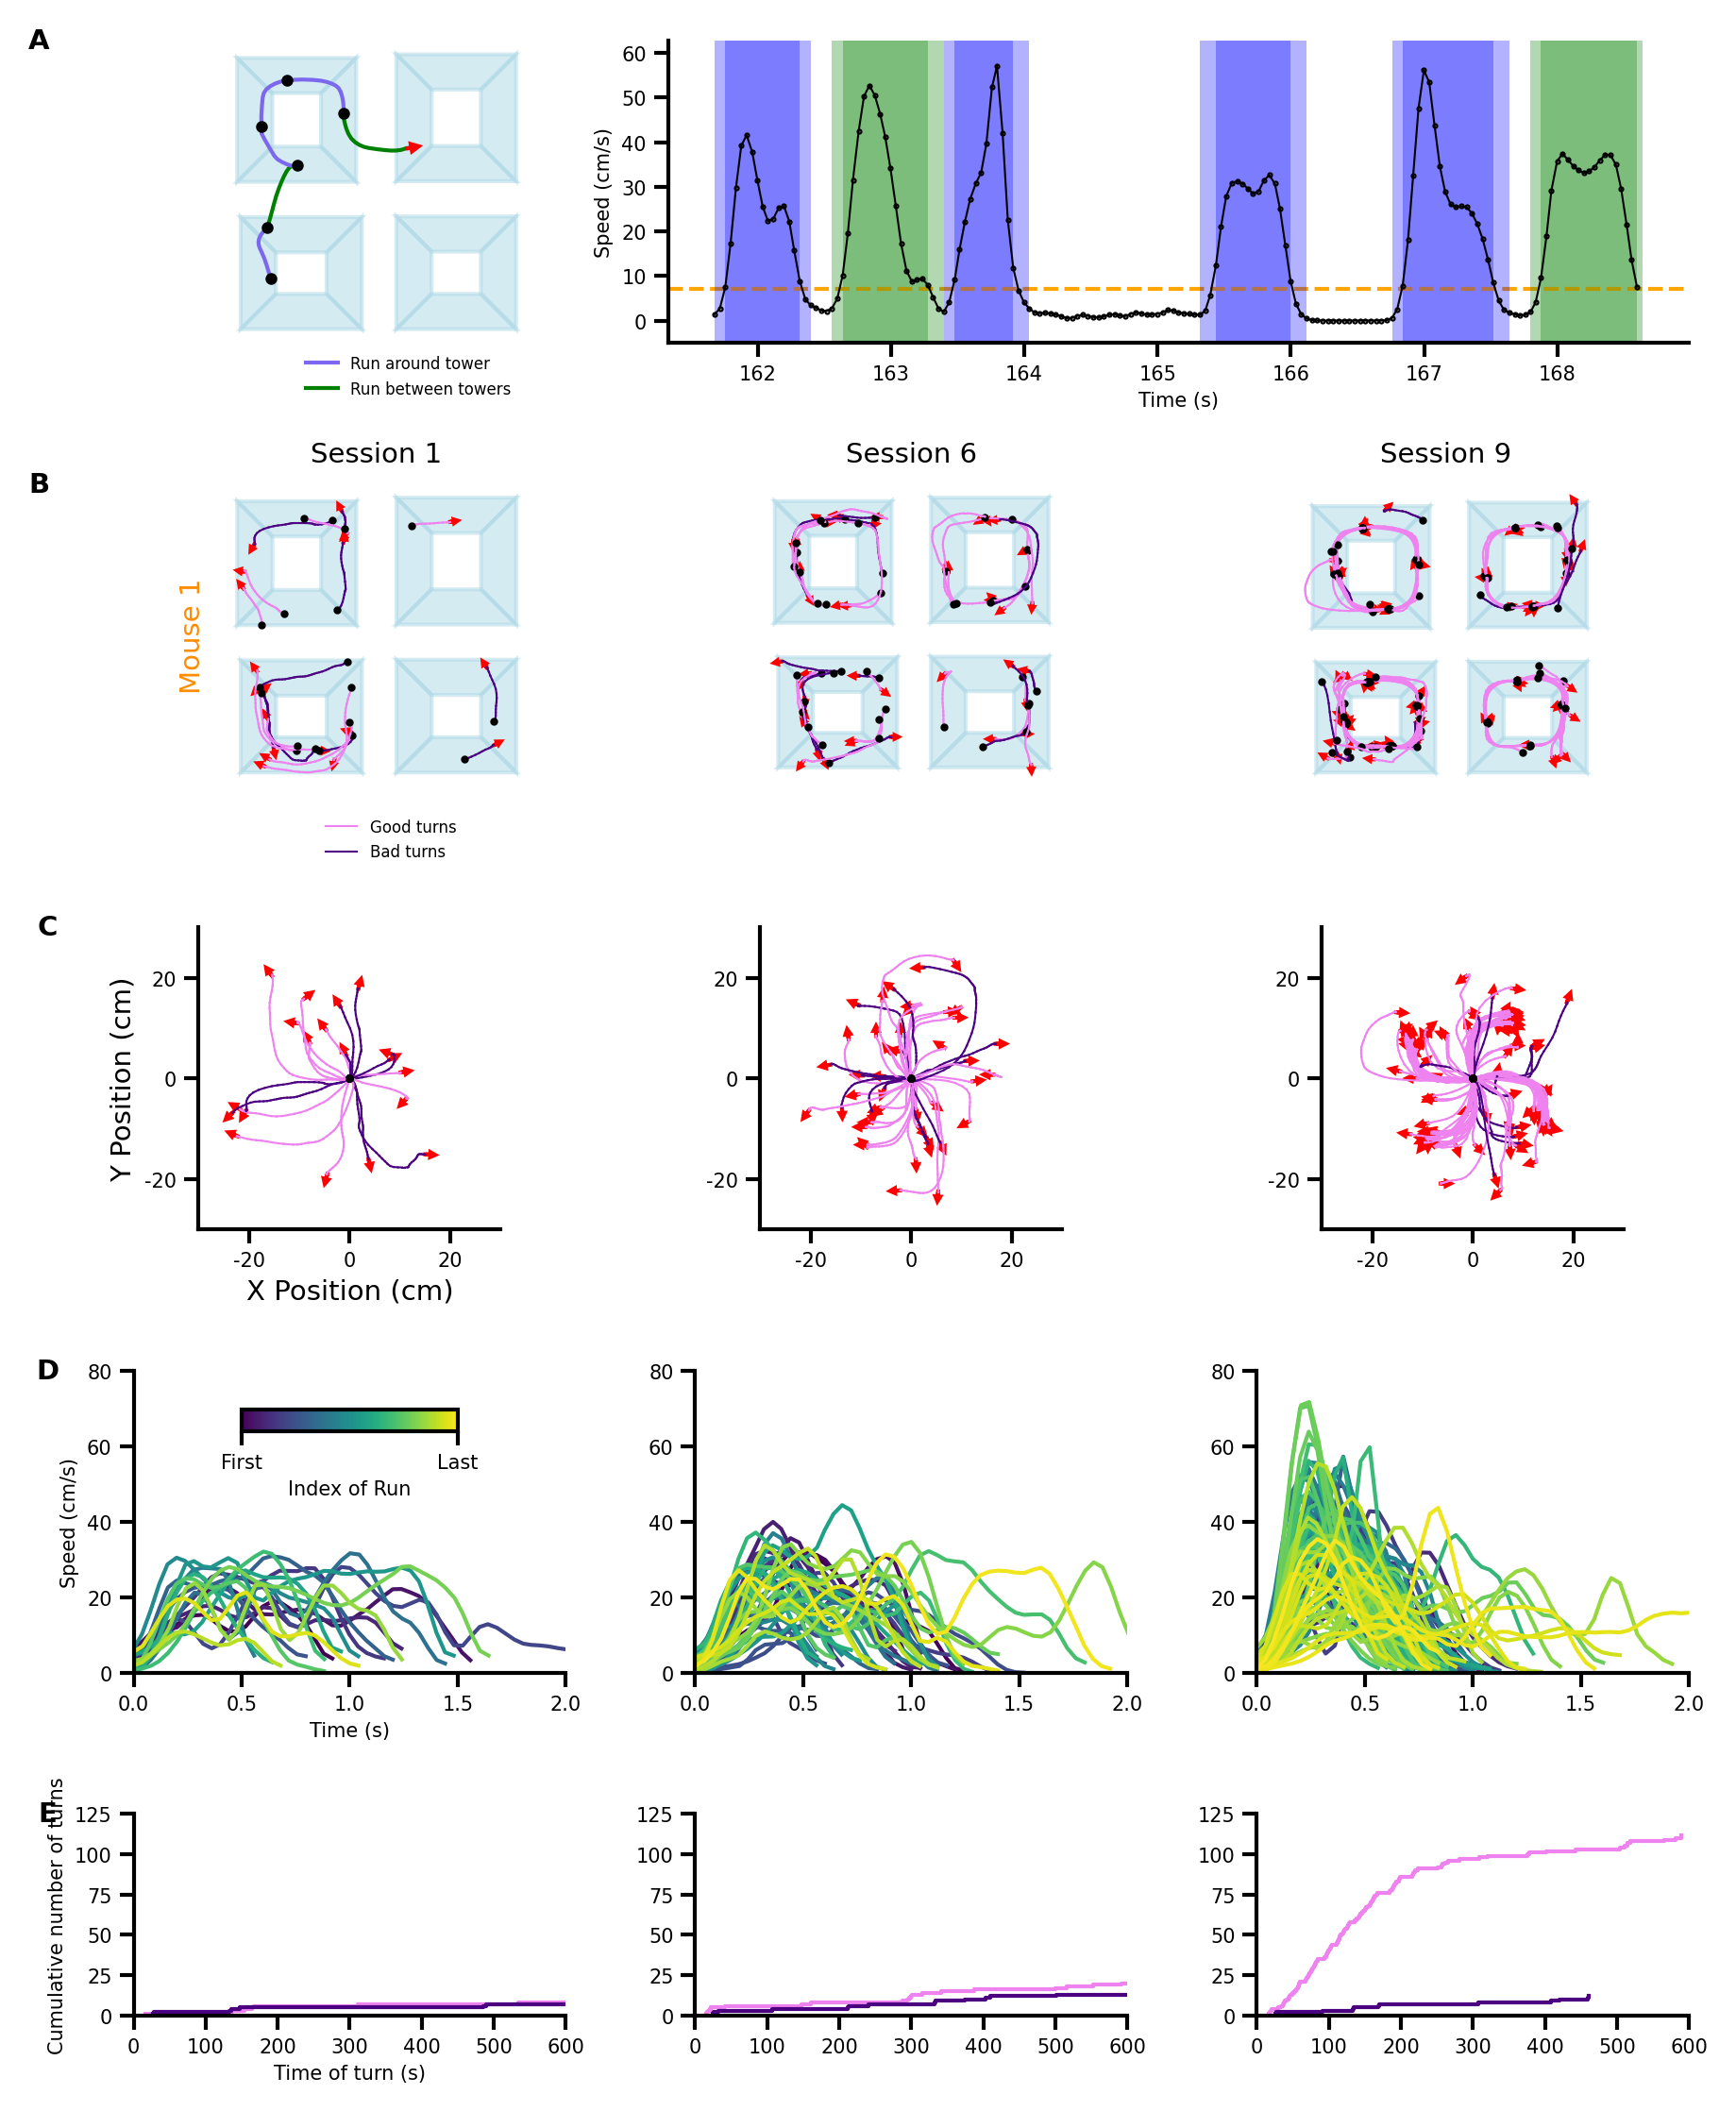

In [102]:


mice_to_compare = ["MOUKA290","MOUKA300"]


folder_path_mouse_to_process = f"/LocalData/ForagingMice/4TowerTaskMethodPaper/KenzaData/{mice_to_compare[0]}"
#session_to_process = session_list[mice_to_compare[0]][8]
#output_pickle_filename = f"{session_to_process}_basic_processing_output.pickle"        
#output_pickle_filepath = os.path.join(folder_path_mouse_to_process, session_to_process, output_pickle_filename)

#with open(output_pickle_filepath, 'rb') as file:
#    session_data = pickle.load(file)

#SOME PROCESSING HERE

###################

# Compute instantaneous distances, speeds, and angular speeds

session_data_list = []

for i in range(len(sessions_to_compare)):


    session_to_process = session_list[mice_to_compare[0]][sessions_to_compare[i]]
    output_pickle_filename = f"{session_to_process}_basic_processing_output.pickle"        
    output_pickle_filepath = os.path.join(folder_path_mouse_to_process, session_to_process, output_pickle_filename)

    with open(output_pickle_filepath, 'rb') as file:
        session_data = pickle.load(file)

    session_data_list.append(session_data)


traj_df, turns_df, param_df=load_data(folder_path_mouse_to_process,session_to_process)

traject_time = session_data['timeofframes']

distances = session_data['distances']
speeds = session_data['speeds']
angular_speeds = session_data['angular_speeds']

smoothed_positions_cm = session_data['positions']
smoothed_Xpositions_cm = smoothed_positions_cm[0]
smoothed_Ypositions_cm = smoothed_positions_cm[1]


###################

# Trapezes_positions
trapeze_width, towers_coordinates = get_trapeze_and_tower_data(folder_path_mouse_to_process, session_to_process)
all_trapezes_coordinates_cm = generate_trapeze_and_tower_coordinates(towers_coordinates, trapeze_width)[0]

# 
# Convert all coordinates
# all_trapezes_coordinates_cm = {}
# for tower, trapezes in all_trapezes_coordinates.items():
#     all_trapezes_coordinates_cm[tower] = {}
#     for trapeze, coords in trapezes.items():
#         all_trapezes_coordinates_cm[tower][trapeze] = [convert_pix_to_cm(coord) for coord in coords]

# Print the result for the trapezes

run_epochs, clean_run_epochs= detect_run_epochs(speeds,traject_time)

runs_between_towers = copy.deepcopy(session_data['all_epochs']['run_between_towers'])


##################################################################################################################################################################################################################

video_resolution = 512, 512 # this gives the resolution in pixel of the video recorded(trajectory of the mice in the maze)  
trapeze_width = 40 # rewards are delivered in the maze around 4 towers,  when mice a switch from one trapze to another

first_epoch_to_plot = 93 # 40 93
last_epoch_to_plot = 99 # 50 99

fig=plt.figure(figsize=(cm2inch(18), cm2inch(23)), dpi=300, constrained_layout=False, facecolor='w')
gs = fig.add_gridspec(5, 1 , hspace=0.5, height_ratios=[3, 3, 3, 3, 2])

#########################################

row1 = gs[0].subgridspec(1, 3, wspace=.1, hspace=.3, width_ratios=[1,1,1])
ax_11 = plt.subplot(row1[0],aspect="equal")
ax_12 = plt.subplot(row1[1:])

#start_index, end_index, trapeze_switch_times = plot_selected_run_epochs(traject_time, smoothed_positions_cm, clean_run_epochs, turns_df, first_epoch_to_plot, last_epoch_to_plot, all_trapezes_coordinates_cm, ax_11)
start_index, end_index, trapeze_switch_times = plot_selected_run_epochs(folder_path_mouse_to_process, session_to_process, first_epoch_to_plot, last_epoch_to_plot, all_trapezes_coordinates_cm, ax_11, show_legend=True)
plot_trajectory_speed_chunk(start_index, end_index, traject_time, speeds, run_epochs, clean_run_epochs, ax_12, folder_path_mouse_to_process, session_to_process, cut_off_speed=7, events_list=None)

ax_11.text(-0.6, 1, 'A', weight='bold', va='center', ha='center', transform=ax_11.transAxes, fontsize=7)


#print(start_index, end_index)

#########################################


row2 = gs[1].subgridspec(1, 3, wspace=.1, hspace=.1, width_ratios=[1,1,1])
ax_21 = plt.subplot(row2[0], aspect="equal")
ax_22 = plt.subplot(row2[1], aspect="equal")
ax_23 = plt.subplot(row2[2], aspect="equal")

ax_21.text(-0.1, 0.5, 'Mouse 1', color='darkorange',rotation=90, va='center', ha='center', transform=ax_21.transAxes, fontsize=7)
ax_21.text(0.5, 1.1, f'Session {sessions_to_compare[0]+1}', va='center', ha='center', transform=ax_21.transAxes, fontsize=7)
ax_22.text(0.5, 1.1, f'Session {sessions_to_compare[1]+1}', va='center', ha='center', transform=ax_22.transAxes, fontsize=7)
ax_23.text(0.5, 1.1, f'Session {sessions_to_compare[2]+1}', va='center', ha='center', transform=ax_23.transAxes, fontsize=7)

ax_2 = [ax_21,ax_22,ax_23]

# plot_run_type(traject_time, smoothed_Xpositions_cm, smoothed_Ypositions_cm, session_data['all_epochs'], towers_coordinates, ax_21, runtype='run_around_tower', all_trapezes_coordinates_cm=all_trapezes_coordinates_cm, q=4)
# plot_run_type(traject_time, smoothed_Xpositions_cm, smoothed_Ypositions_cm, session_data['all_epochs'], towers_coordinates, ax_22, runtype='run_around_tower', all_trapezes_coordinates_cm=all_trapezes_coordinates_cm, q=4)
# plot_run_type(traject_time, smoothed_Xpositions_cm, smoothed_Ypositions_cm, session_data['all_epochs'], towers_coordinates, ax_23, runtype='run_around_tower', all_trapezes_coordinates_cm=all_trapezes_coordinates_cm, q=4)

for j in range(len(sessions_to_compare)):

    plot_run_type(folder_path_mouse_to_process, session_list[mice_to_compare[0]][sessions_to_compare[j]], session_data_list[j]['all_epochs'], ax_2[j], runtype='run_around_tower', all_trapezes_coordinates_cm=all_trapezes_coordinates_cm, q=4, time_start=time_start, time_end=time_end)

ax_11.text(-0.6, 1, 'B', weight='bold', va='center', ha='center', transform=ax_21.transAxes, fontsize=7)

#########################################

row3 = gs[2].subgridspec(1, 3, wspace=.3, hspace=.3, width_ratios=[1,1,1])
ax_31 = plt.subplot(row3[0], aspect="equal")
ax_32 = plt.subplot(row3[1], aspect="equal")
ax_33 = plt.subplot(row3[2], aspect="equal")

ax_3 = [ax_31,ax_32,ax_33]


for k in range(len(sessions_to_compare)):

    plot_runs_around_towers_origin(folder_path_mouse_to_process, session_list[mice_to_compare[0]][sessions_to_compare[k]], ax_3[k], q=4, time_start=time_start, time_end=time_end, show_xlabel= True if k==0 else False, show_ylabel= True if k==0 else False, show_legend= True if k==0 else False, xlim=(-30,30), ylim=(-30,30))
    ax_3[k].set_xticks([-20, 0, 20])
    ax_3[k].set_yticks([-20, 0, 20])

ax_31.text(-0.5, 1, 'C', weight='bold', va='center', ha='center', transform=ax_31.transAxes, fontsize=7)

#########################################

row4 = gs[3].subgridspec(1, 3, wspace=.3, hspace=.3, width_ratios=[1,1,1])
ax_41 = plt.subplot(row4[0])
ax_42 = plt.subplot(row4[1])
ax_43 = plt.subplot(row4[2])

ax_4 = [ax_41, ax_42, ax_43]

for l in range(len(sessions_to_compare)):

    plot_runs_around_speed_profiles(folder_path_mouse_to_process, session_list[mice_to_compare[0]][sessions_to_compare[l]], ax_4[l], time_start=time_start, time_end=time_end, xlim=(0,2), ylim=(0,80), show_xlabel= True if l==0 else False, show_ylabel= True if l==0 else False, show_color_bar= True if l==0 else False)

ax_41.text(-0.2, 1, 'D', weight='bold', va='center', ha='center', transform=ax_41.transAxes, fontsize=7)

#########################################

row5 = gs[4].subgridspec(1, 3, wspace=.3, hspace=.3, width_ratios=[1,1,1])
ax_51 = plt.subplot(row5[0])
ax_52 = plt.subplot(row5[1])
ax_53 = plt.subplot(row5[2])

ax_5 = [ax_51, ax_52, ax_53]

for m in range(len(sessions_to_compare)):

    show_xlabel= True if m==0 else False
    show_ylabel = True if m==0 else False
    xlim = [0,600]
    ylim = [0,125]

    plot_cumulated_turns_time_profile(folder_path_mouse_to_process, session_list[mice_to_compare[0]][sessions_to_compare[m]], ax_5[m], time_start=time_start, time_end=time_end, xlim=xlim, ylim=ylim , show_xlabel=show_xlabel, show_ylabel=show_ylabel, show_legend= False)

ax_41.text(-0.2, 1, 'E', weight='bold', va='center', ha='center', transform=ax_51.transAxes, fontsize=7)

#########################################



plt.show()


In [89]:
3.6*0.3

1.08